In [1]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler
import itertools

In [2]:
import warnings
warnings.filterwarnings(action='once')

In [3]:
#Load data
bmb_serie = pd.read_csv(r"..\Datos\canasta_basica_serie.csv",index_col=0)

<AxesSubplot:>

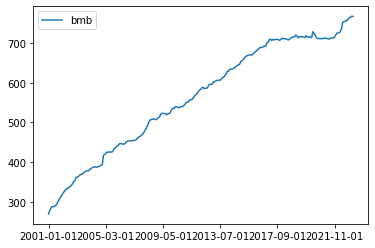

In [4]:
bmb_serie.columns = ['bmb']
bmb_serie.plot()

In [5]:
#Errors
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual))  # MAPE
    me = np.mean(list(np.array(forecast) - np.array(actual)))             # ME
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual))))    # MAE
    mpe = np.mean((list(np.array(forecast) - np.array(actual)))/np.array(actual))   # MPE
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'corr':corr})

In [6]:
def grid_search(hidden, act,solv, alfa, error):
    '''
    Grid search process to find optimal solution within a list of given parameters
    '''
    best_e=float('inf')
    test_y = bmb_serie[-tt-tv:-tv].bmb.tolist()

    for h in hidden:
        print(h)
        for ac in act:
            for s in solv:
                for a in alfa:
                        try:
                            model = MLPRegressor(hidden_layer_sizes=h,activation=ac,solver=s,
                             alpha=a,
                             learning_rate = 'adaptive', max_iter=1000, random_state=1993)
                            model.fit(x_train, y_train[:,0])

                            y_test_pred = model.predict(x_test).reshape(-1,1)

                            # Scaling the predictions
                            y_test_pred = scaler.inverse_transform(y_test_pred)

                            errors=forecast_accuracy([i[0] for i in y_test_pred], test_y)
                            e = errors[error]
                            if e<best_e:
                                opt_params = [h,ac,s,a]
                                best_e=e 
                                print(opt_params,best_e)
                        except:
                            print("Error")
                    
    print('BEST: ',opt_params, best_e)
    return opt_params

In [7]:
t =12
tt = 12
tv = 3

train= bmb_serie[:-tt-tv] #Reduced
test = bmb_serie[-tt-tv-t:-tv]
validation = bmb_serie[-tv-t:]


scaler = MinMaxScaler()
#train_data = scaler.fit_transform(train)
#test_data = scaler.transform(test)

test_data = scaler.fit_transform(test)
train_data = scaler.transform(train)
val_data = scaler.transform(validation)

# Converting to numpy arrays
timesteps =t+1

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
print(train_data_timesteps.shape)

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
print(test_data_timesteps.shape)

val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
print(val_data_timesteps.shape)

(240, 13)
(12, 13)
(3, 13)


In [8]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(240, 12) (240, 1)
(12, 12) (12, 1)
(3, 12) (3, 1)


hl1 = [100,120,200,240,300,360]
act1 = ['relu','tanh','identity','logistic']
sol1 = ['lbfgs', 'sgd','adam']
a1 = [0.00001,0.0001,0.001,0.01,0.1,1,2]


opt_params = grid_search(hl1, act1,sol1, a1, 'mae')

print(opt_params)

model = MLPRegressor(hidden_layer_sizes=opt_params[0],activation=opt_params[1],solver=opt_params[2],
                     alpha=opt_params[3],
                     learning_rate = 'adaptive', max_iter=1000, random_state=1993)

model.fit(x_train, y_train[:,0])

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)
y_val_pred = model.predict(x_val).reshape(-1,1)

# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_val_pred = scaler.inverse_transform(y_val_pred)

x = forecast_accuracy([i[0] for i in y_train_pred], bmb_serie[t:-tt-tv].bmb.tolist())
print(x)
xt=forecast_accuracy([i[0] for i in y_test_pred], bmb_serie[-tt-tv:-tv].bmb.tolist())
print(xt)
xv=forecast_accuracy([i[0] for i in y_val_pred], bmb_serie[-tv:].bmb.tolist())
print(xv)

In [9]:
model = MLPRegressor(hidden_layer_sizes=200,activation='identity',solver='lbfgs',
                     alpha=0.01,
                     learning_rate = 'adaptive', max_iter=1000, random_state=1993)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train).reshape(-1,1)
y_train_pred = scaler.inverse_transform(y_train_pred)

y_test_pred = model.predict(x_test).reshape(-1,1)
y_test_pred = scaler.inverse_transform(y_test_pred)

y_val_pred = model.predict(x_val).reshape(-1,1)
y_val_pred = scaler.inverse_transform(y_val_pred)

x = forecast_accuracy([i[0] for i in y_train_pred], bmb_serie[12:-tt-tv].bmb.tolist())
print(x)
xt=forecast_accuracy([i[0] for i in y_test_pred], bmb_serie[-tt-tv:-tv].bmb.tolist())
print(xt)
xv=forecast_accuracy([i[0] for i in y_val_pred], bmb_serie[-tv:].bmb.tolist())
print(xv)

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mape': 0.0032277596766489797, 'me': -0.0016871141442614146, 'mae': 1.7608984890323989, 'mpe': 3.414375636792652e-05, 'rmse': 2.6453950569087494, 'corr': 0.9997772850742305}
{'mape': 0.004210967742415306, 'me': -2.70092483185843, 'mae': 3.1423505056416823, 'mpe': -0.0036197756967975554, 'rmse': 5.0446128039844735, 'corr': 0.9597150581929715}
{'mape': 0.0029530311541566246, 'me': 0.11753370645256685, 'mae': 2.2620631039311547, 'mpe': 0.00015097971222270516, 'rmse': 2.520922979421327, 'corr': 0.75251253149504}


In [10]:
xtr = np.array([x_test[0]])
y_test_pred = []
for _ in range(tt):
    pred = model.predict(xtr).reshape(-1,1)
    xtr = np.array([np.concatenate((xtr[0],pred[0]))[1:]])
    y_test_pred.append(scaler.inverse_transform(pred)[0][0])

xvr = np.array([x_val[0]])
y_val_pred = []
for _ in range(tv):
    pred = model.predict(xvr).reshape(-1,1)
    xvr = np.array([np.concatenate((xvr[0],pred[0]))[1:]])
    y_val_pred.append(scaler.inverse_transform(pred)[0][0])
xt=forecast_accuracy(y_test_pred, bmb_serie[-tt-tv:-tv].bmb.tolist())
print(xt)

xv=forecast_accuracy(y_val_pred, bmb_serie[-tv:].bmb.tolist())
print(xv)

{'mape': 0.02669874204914204, 'me': -20.121878615018932, 'mae': 20.121878615018932, 'mpe': -0.02669874204914204, 'rmse': 23.684304209547072, 'corr': 0.9012580615230444}
{'mape': 0.002544197875217471, 'me': -1.9491979725490864, 'mae': 1.9491979725490864, 'mpe': -0.002544197875217471, 'rmse': 2.417883504202029, 'corr': 0.593439443207051}


In [11]:
x_final = np.array([x_val[-1]])
y_final_pred = []
for i in range(9):
    pred = model.predict(x_final).reshape(-1,1)
    x_final = np.array([np.concatenate((x_final[0],pred[0]))[1:]])
    y_final_pred.append(scaler.inverse_transform(pred)[0][0])
y_final_pred

[770.1893952155756,
 772.6055550926369,
 774.2155609593841,
 774.7246675733185,
 775.0796315007526,
 775.8094219221085,
 776.5044690345464,
 777.0294234842412,
 777.637284417655]

In [12]:
np.savetxt(r'..\Datos\mlp_prediction.csv',np.array(y_final_pred), fmt = '%f', delimiter=",")